# MultivariateAnalysis_08-04-2022_MartinASchepers

In [110]:
# Import of the necessary libraries
import pandas as pd
import numpy as np
import warnings
import warnings
warnings.filterwarnings("ignore")
## Building Model
from sklearn import linear_model
from scipy import stats
from sklearn import datasets
import sklearn
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set()
## Multidimensional Scaling
from sklearn.manifold import MDS
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Galton.dat dataset
### File Information
The file galton.dat contains the original data from Galton, which was used to formulate the notion of regression. It comprises measurements of lengths of children and their parents, number of children, the gender of the subjects and a identifier for the family.

### Data exploration
Before deciding on what analysis to perform, the data should be explored a little.

In [111]:
# The .dat file seems to be separated with tabs, thus read csv should be able to open it
galton = pd.read_csv('galton.dat', sep='\t')
galton.head()

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,1.0,0.0
1,1,78.5,67.0,F,69.2,4,0.0,1.0
2,1,78.5,67.0,F,69.0,4,0.0,1.0
3,1,78.5,67.0,F,69.0,4,0.0,1.0
4,2,75.5,66.5,M,73.5,4,1.0,0.0


The variables "father" and "mother" and "height" seem to be respectively the heights of the father, mother and then of the child itself. Kids the number of children the couple has and male/female bolean values of for gender. There is also a column "gender" that reveals exact the same information but as categories instead of bolean values.

In [112]:
# "describe" gives a lot of information on each column
galton.describe()

,father,mother,height,kids,male,female
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,69.232851,64.084410,66.760690,6.135857,0.517817,0.482183
std,2.470256,2.307025,3.582918,2.685156,0.499961,0.499961
min,62.000000,58.000000,56.000000,1.000000,0.000000,0.000000
25%,68.000000,63.000000,64.000000,4.000000,0.000000,0.000000
50%,69.000000,64.000000,66.500000,6.000000,1.000000,0.000000
75%,71.000000,65.500000,69.700000,8.000000,1.000000,1.000000
max,78.500000,70.500000,79.000000,15.000000,1.000000,1.000000


The heights (father, mother and height) likely are given in inches. Kids is a count of how many kids, male and female seem to be boloean values (1:yes, 0:no) and this is repeated in the gender column (M/F)

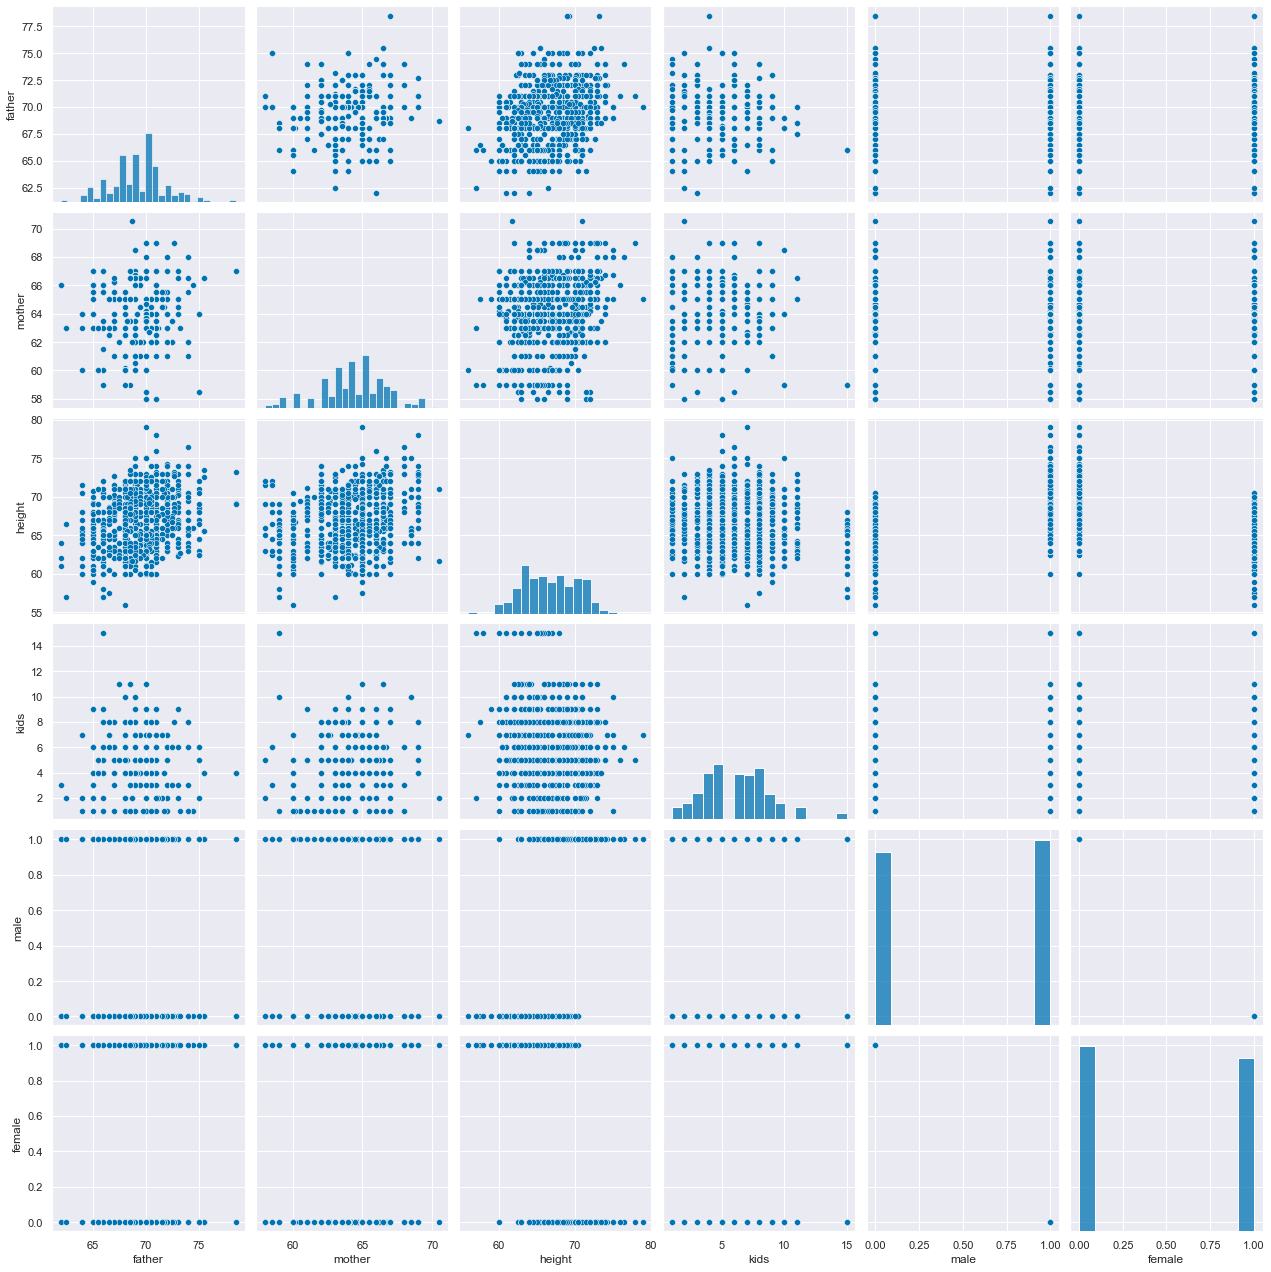

In [113]:
# Visualize the data using scatter plot and histogram
# To view if there are any clear correlation, the variables are scattered against each other. 
# Histagrams are plotted to show the distribution of the data.
sns.set_palette('colorblind')
sns.pairplot(data=galton, height=3)

Male and Female very clearly reveal bolean values again, the remaining scatterplots give a little more info together with the histograms. There does not seem to be anything noticeable in number of kids plotted against the other variables. 

Looking at the scatter for height vs mother/father there seems to be a very slight linear relationship. This would perhaps be valuable investigating.

### 1st Analysis: Galton data, Statistical Method (MLR) and justification
 [Francis Galton was developing ways to quantify the heritability of traits](https://rdrr.io/cran/mosaicData/man/Galton.html). Galton proposed that parents their heights influences that of their children which as today is a common concept in heritability.

This would suggest that the childrens height would be the dependent variable, whereas the independent variables would be 'father' and 'mother' height. It could be argumented that gender is also a very important factor for height as men are usually taller. However this might be less pronounced for children.

Considering the above information about the data, the most logical method for analyzing this would be <u>Multilinear Regression</u>. Multilinear regression is a technique used to estimate the relationship between two or more independent variables (in this case parents height) and one dependent variable (the child's height) [source](https://www.scribbr.com/statistics/multiple-linear-regression/). Father and mother would normally not be related in height, whereas their child due to inheriting their genes might be a combination of both.

In [114]:
# First check for missing data and remove if present as the analysis would be missing info.
galton.isna().sum()

family    0
father    0
mother    0
gender    0
height    0
kids      0
male      0
female    0
dtype: int64

### Construction of a model
The sklearn library allows us to construct a linear model out of the different variables that can that make predictions based on new data. It however only takes numerical data, thus categorial data/strings should not be included.

When constructing the model, sklearn looks for the best-fit line for each independent variable. It will select on the regression coefficients that lead to smallest model error, it will look at the model's t-statistic (whether the model is properly predicting the values) and finally the p-values (likelyhood to find the set of observations based on whether the null hypothesis is true). Finally, based on these values it constructs the best fitting line through the data.

In [115]:
# columns = ['family', 'father', 'mother', 'gender', 'height', 'kids', 'male', 'female']

# Select independent and dependent variables
X = galton[['father', 'mother']]
y = galton['height']

# Initialize model from sklearn and make a fit for our data
regr = linear_model.LinearRegression()
model = regr.fit(X, y)

print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 22.309705489589717
Coefficients: [0.37989697 0.28321451]


In [116]:
# To make a quick prediction with the model, we look at the first entry of the 
# dataset, where the father is 78.5 inches, the mother 67.0 and 73.2
father = 78.5
mother = 67.0

print('A child should have an height of about {:.0f} inches, if the father is {} inches tall and the mother {} inches tall.'.format(
    model.predict([[float(father), float(mother)]])[0], father, mother))

A child should have an height of about 71 inches, if the father is 78.5 inches tall and the mother 67.0 inches tall.


The predicted value is not quite the same as the actual value, but comes relatively close. Either way, the model now has to be validated. If this does not seem to be possible, then perhaps children heights might be explained then more then just parents height. In the next step a 3D plot will be created containing the original data as well as the predicted data. This will allow us to better visually observe how close the actual data is to the model.

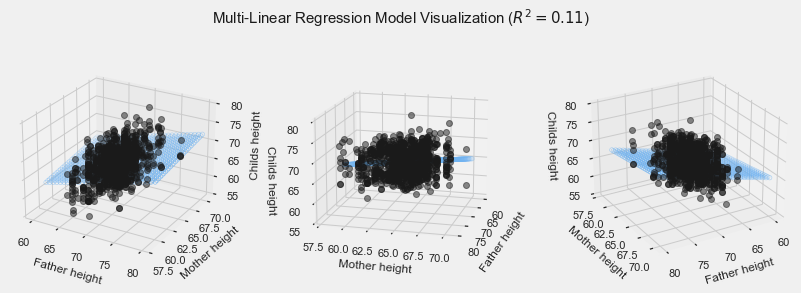

In [117]:
# Prepare data
X = galton[['father', 'mother']].values.reshape(-1,2)
Y = galton['height']

# Create range for each dimension
x = X[:, 0]
y = X[:, 1]
z = Y

# The selected linspace values were based on the min and max values of the parent's height (see describe())
xx_pred = np.linspace(60, 80, 30)  # range of father heights
yy_pred = np.linspace(60, 70, 30)  # range of mother heights
xx_pred, yy_pred = np.meshgrid(xx_pred, yy_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Predict using model built on previous step
# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
predicted = model.predict(model_viz)

# Evaluate model by using it's R^2 score
r2 = model.score(X, Y)

# Plot model visualization
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Father height', fontsize=12)
    ax.set_ylabel('Mother height', fontsize=12)
    ax.set_zlabel('Childs height', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=25, azim=-60)
ax2.view_init(elev=15, azim=15)
ax3.view_init(elev=25, azim=60)

fig.suptitle('Multi-Linear Regression Model Visualization ($R^2 = %.2f$)' % r2, fontsize=15, color='k')

fig.tight_layout()

Quickly observing the plot, the prediction does seem to properly go through the middle of the data. However the R^2 value suggests this model might be a poor fit

In [118]:
# Gets additional information about the model
X = galton[['father', 'mother']]
X = sm.add_constant(X) # adding a constant

olsmod = sm.OLS(galton['height'], X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     54.69
Date:                Fri, 08 Apr 2022   Prob (F-statistic):           3.92e-23
Time:                        15:54:56   Log-Likelihood:                -2367.9
No. Observations:                 898   AIC:                             4742.
Df Residuals:                     895   BIC:                             4756.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3097      4.307      5.180      0.0

Once again, the R-squared value seems to be very low as well as the adjusted R-squared value, as these suggest the model only seems to explain about 10% of the variance of the data. Additionally there is a warning that the condition number is large which might for example indicate strong multicollinearity. 
Multicollinearity however, only affects the coefficients and p-values, but it does not influence the model’s ability to predict the dependent variable ( see: [When do I have to fix Multicollinearity?](https://machinelearningmind.com/2019/10/19/multicollinearity-how-to-fix-it/)).

### Conclusion Galton and Multilinear regression
As the multilinear model including just the parent's height seems to explain very little (about 10% of the variation), it is very likely there are other factors in play. One of those factors could for example be the gender of the child. It is common that men are higher then women, but this does not necessarily reflect during childhood. Making use of additional variables from the dataset might better explain the variance in the data.

## 2nd Analysis Galton and PCA
As seen previously, very little of the dataset could be explained by the model. Thus I propose a PCA, a dimensionality reduction technique which linearly transforms the correlated variables into a smaller number of uncorrelated variables. Perhaps not only the parents length, but also gender or even the number of children per family might explain the height of the children.

In [119]:
rand_state = 1000
from pca import pca

In [120]:
galton.columns
# Drop part of the columns, as not all are relevant and some are redundant
galt2 = galton.drop(['family', 'gender', 'female'], axis=1)
male = galt2.male

PCA consists of multiple steps, which will be performed by the pca package. First, it will normalize the data. This is necessary because we are no longer just taking height/inches of people anymore. We have the bolean value for gender as well as number of children. Considering these are very different scales, the data should be normalized. The package then calculated the covariance matrix (a matrix containing each item pair by pair and their covariance) and splits it into scale part (eigenvalues) and direction part (eigenvectors).

In [121]:
# normalisation is done because the scales are different (height, number of children and male or not)
model = pca(n_components=4, normalize=True)
results = model.fit_transform(galt2)

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


The loadings are defined by the eigenvalues * sqrt(eigenvalues) ([source](https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another)) and give us more insight correlation of variables.

In [122]:
loadings=results["loadings"]
loadings

,father,mother,height,kids,male
PC1,-0.270790,-0.174408,-0.695536,0.211768,-0.606333
PC2,-0.638891,-0.378395,0.091614,0.480971,0.457066
PC3,0.133036,-0.824088,-0.083720,-0.537381,0.085982
PC4,-0.663922,0.337519,-0.080650,-0.659539,0.061588


The values seem to be very varying and most correlation seems to be PC2 and male.

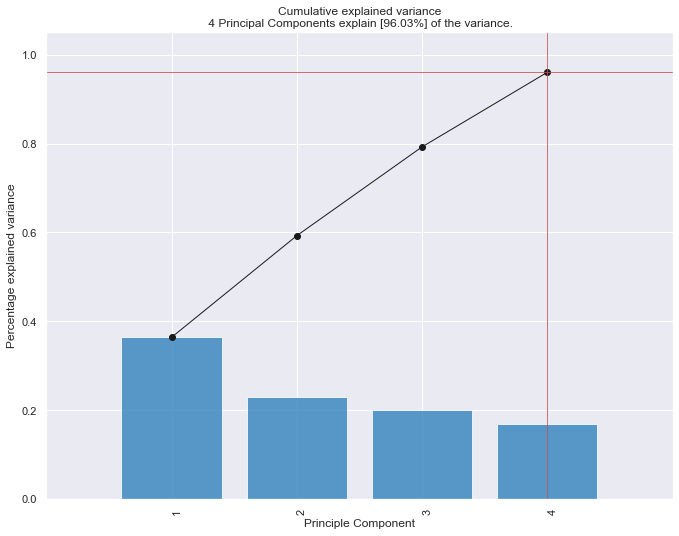

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 4 Principal Components explain [96.03%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [57]:
model.plot(figsize=(10,8))

According to the above visualization, 4 components seem to be able to explain about 96% of the dataset. Whereas the 1st principal component explains almost 40%. To get a little bit more insight, a biplot will be generated next step to view the features that most influence the dataset.

[pca] >Plot PC1 vs PC2 with loadings.


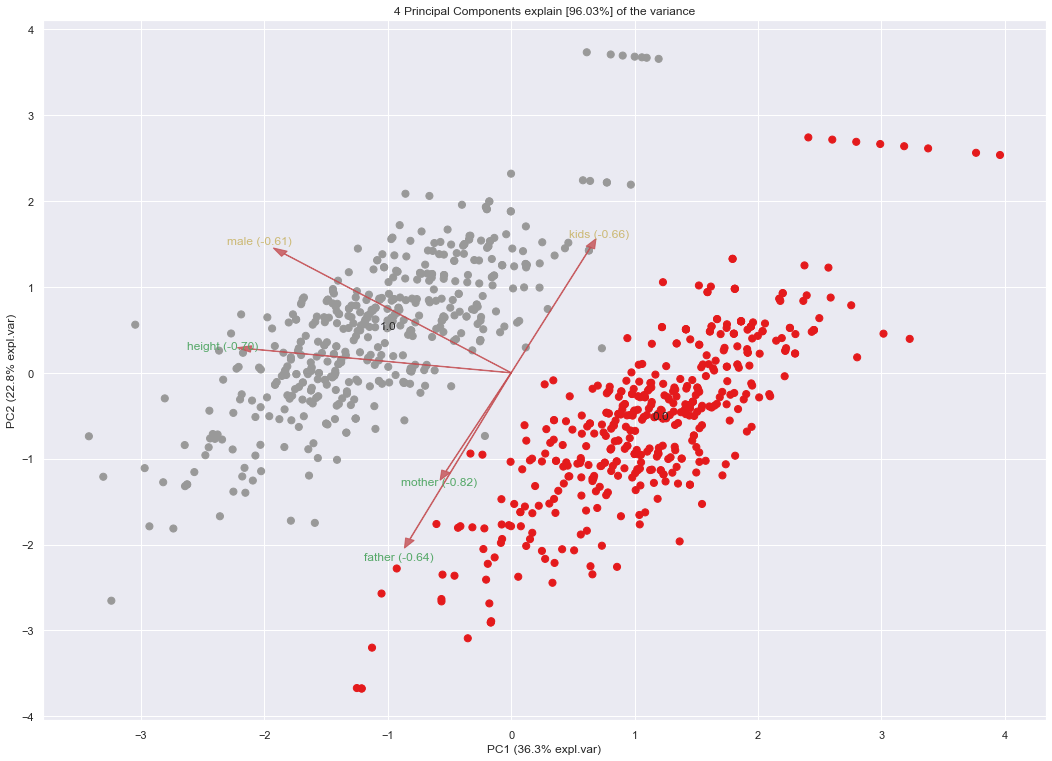

(<Figure size 1152x864 with 1 Axes>,
 <AxesSubplot:title={'center':'4 Principal Components explain [96.03%] of the variance'}, xlabel='PC1 (36.3% expl.var)', ylabel='PC2 (22.8% expl.var)'>)

In [60]:
model.biplot(n_feat=5, legend=False, figsize=(16,12), y=male, label=True)

The first PC explains 36.3% and the second PC 22.8%. There seems to be a very clear distinction of girls and boys according to the colored markings as well as the 'male' feature which denotes whether the person is male or female. Height also seems to be relatively in the same direction suggesting at least some correlation. The most interesting factor however, it that parent's heigh seems to be in the opposite direction of number of children (feature: kids). An argument would be that tall people usually have less children, but this would be quite a strange conclusion. It is known that tall people sometimes have [higher salaries](https://www.everydayhealth.com/healthy-living-pictures/12-big-and-little-facts-about-your-height.aspx), but this is caused by societal factors and would not be relevant to this question as we are trying to infer whether parents height affect the height of the children.
The parents are not perfectly perpendicular to 'height' and thus these might have some effect on the childrens height, but this only explains a very small amount.

### Conclusion
From of the available results, it is most likely that the height of the children is primarily determined by the gender. Parent's height do seem to play a small part in this, which could be explained by genetics, but are most likely not the most important factor. For a future analysis, it would perhaps be wise to split the children by gender to eliminate this variance. As the different genders are clearly different, splitting them might give a better insight whether there might indeed be a genetic reason.

## 3rd Analysis Transhydrogenase and MDS

### Information data
The data contains information about the wildtype and mutant forms of the protein transhydrogenase (TH). A Procrustus Analaysis has already been performed on this dataset. The data originally being the coordenates for each specific variant, they are bound to be very different. Comparing them immediatly would give very little information, thus Procrustus aligned them to each other as closely as possible ([finding an optimal scale, rotation and translation](https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421)). 

This leaves a dataset with "similar looking" molecule coordenates for further analysis. Considering these are coordenates and we aim to see whether any clusters are formed based on their shapes/coordenates, Multidimensional scaling would be an appropriate technique. [Multidimensional scaling](https://blog.paperspace.com/dimension-reduction-with-multi-dimension-scaling/) is a technique that allows us to reduce the dimensions of the data whilst still preserving the distances and dissimilarities between samples.

In [90]:
# Load the data
trhyd = pd.read_csv('transhydrogenase.csv')

In [98]:
# Save the columns with variants to later use as label
variables = trhyd.variant

In [91]:
# Drop the categorical/label data, as we are looking only at the categories.
trhyd2 = trhyd.drop(['Unnamed: 0', 'variant'], axis=1)
trhyd2

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z750,x751,y751,z751,x752,y752,z752,x753,y753,z753
0,2.232662,-0.175234,0.445381,1.430379,0.362950,0.900745,1.328980,0.169134,0.928455,0.751823,...,-6.055492,2.278352,-1.216520,-7.968948,1.648216,-0.388278,-7.311485,-0.185457,2.266832,-9.651554
1,3.128979,0.057618,1.338539,2.272053,-0.152276,1.830578,1.497686,-0.200720,1.630493,1.148752,...,-5.384182,2.084931,-0.777718,-6.925377,1.764271,-0.837972,-5.649639,-1.866464,1.002639,-7.600162
2,3.667753,-0.210762,0.915047,2.665825,0.011532,1.561668,1.802264,-0.424967,1.621994,1.279953,...,-6.950081,3.190837,-1.746283,-8.502846,2.848035,-1.168078,-7.571968,-0.521151,0.882258,-9.594967
3,3.703590,-0.266571,1.048084,2.949226,0.039815,1.500355,2.122021,-0.107710,1.381912,1.502676,...,-5.943760,3.890735,-0.656552,-7.033615,3.355130,-0.573520,-5.763386,0.288879,1.581337,-7.494667
4,1.998403,0.659392,0.445759,1.526339,0.522686,0.568974,0.987137,0.083764,0.664909,0.588553,...,-6.176762,4.113041,-0.970990,-7.908390,3.842464,-0.370223,-7.094711,0.451301,1.645195,-8.377224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120,-2.669084,-2.427289,1.191936,-3.375092,-2.794824,1.576153,-3.153336,-2.452126,1.383522,-2.903324,...,-2.579731,2.867694,-1.671361,-4.697720,3.653665,-0.951294,-4.252853,1.799057,1.716810,-6.352692
6121,-2.534512,-3.458969,1.781811,-2.962809,-3.648747,1.954781,-2.387674,-2.991880,1.766689,-2.032077,...,-2.592834,1.196180,-2.404241,-4.204964,1.558762,-1.355719,-4.147633,-1.555199,0.740530,-5.365902
6122,-3.776776,-1.480571,1.286007,-3.855790,-2.406792,1.365089,-4.006705,-2.379490,1.199772,-3.363187,...,-2.118729,1.417145,-1.798042,-4.020084,1.731073,-1.428401,-3.184464,-1.886903,0.396953,-3.909542
6123,-3.246824,-3.914128,1.616825,-3.506781,-3.975917,1.706188,-3.089157,-3.196330,1.425488,-2.588777,...,-2.978657,2.836495,-2.983917,-4.694382,3.326640,-2.095344,-4.414188,1.949281,0.512129,-6.511025


The sklearn mds package allows us to perform multidimensional scaling on the dataset. It will first perform a fit_transform, the fit calculates the mean and variance for each feature in our dataset. "Transform" then transforms all of the features using their respective mean and variance based on the model it constructs ([source](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)).

In [92]:
mds = MDS(random_state=0)
X_transform = mds.fit_transform(trhyd2)
print(X_transform)

[[-45.45385413  71.59563182]
 [-41.73189736  67.05733435]
 [-50.60026065  91.00320045]
 ...
 [113.01200642  70.29990624]
 [102.40786758  86.6873471 ]
 [105.59477337  72.20646817]]


In [93]:
stress = mds.stress_
print(stress)

17378352087.192326


The stress above, shows how well the MDS can reproduce the input data . The closer to zero, the better it works. The large number suggests that it is not able to correctlty reproduce the data. A large value is usually caused by having too little dimensions([source](http://analytictech.com/networks/mds.htm)), however this seems very unlikely... Perhaps because of the large number of dimensions the method does not function entirely correctly. For a future analysis, some sort of resampling should be performed.

Finally, the transformed data is plotted in the next step.

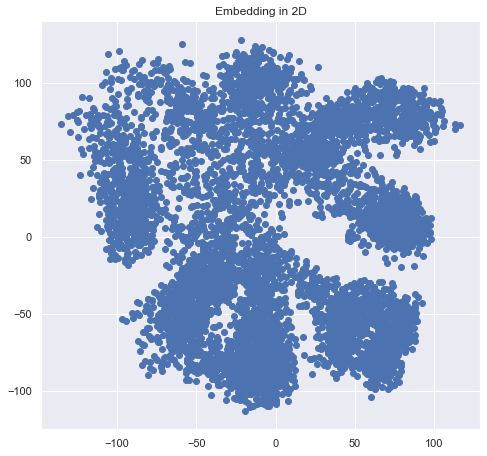

In [95]:
plt.scatter(X_transform[:,0], X_transform[:,1])
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Several samples seem to form clusters, however we do not know yet whether any cluster is specifically formed by the WT variant. Thus we will color it in the next step.

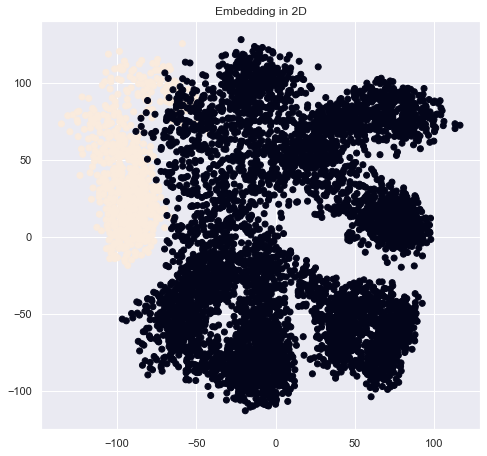

In [100]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=(variables == 'WT'))
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

In yellow we can see that the WT variant clearly clusters in the top-left. This would of course be quite logical, but it should be taken with a grain of salt as the stress value was very high. However, if these results are indeed correct, we can assume that the WT does indeed differ in conformation from the mutants.